Error al generar la señal: float() argument must be a string or a number, not 'TensorVariable'


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [mass1]


Sampling 2 chains for 500 tune and 1_000 draw iterations (1_000 + 2_000 draws total) took 3 seconds.


Número de señales nulas generadas: 1
         mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
mass1  27.957  13.19   5.412   47.448      0.474    0.336     794.0     939.0   
mass2  27.957  13.19   5.412   47.448      0.474    0.336     794.0     939.0   

       r_hat  
mass1    1.0  
mass2    1.0  
Mass1 promedio: 27.956712559612765


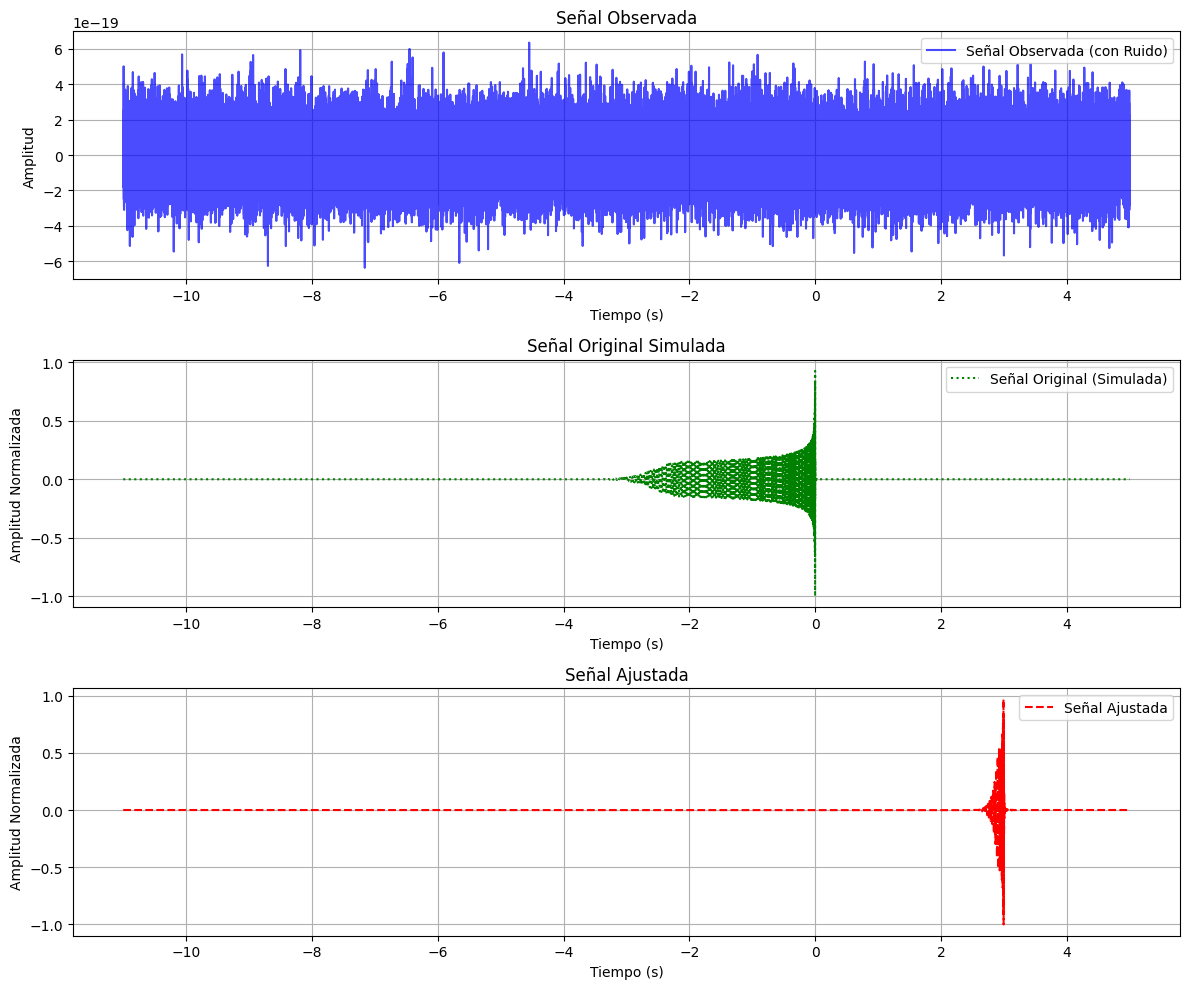

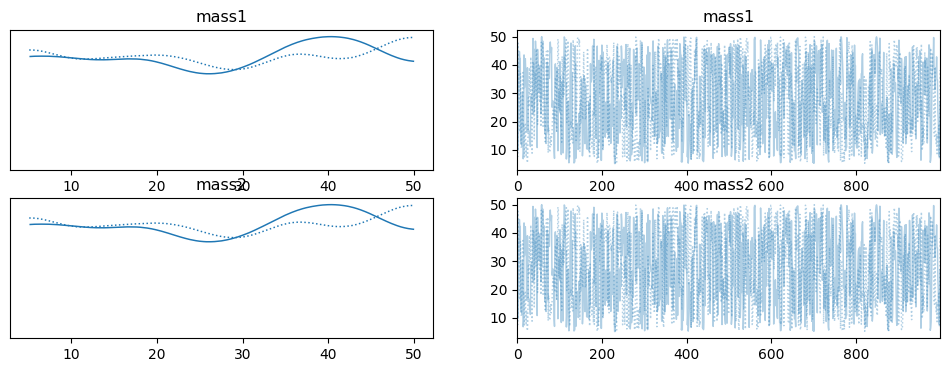

Señal 1: Máximo valor = 0.0


In [6]:
#mass1=mass2

#Creo que el error está en que get_td_waveform (números) devuelve un objeto incompatible con PyMC (TensorVariable)

#El likelihood personalizado "soluciona" eso devolviendo una señal nula cada vez que está esa incompatibilidad. 
#Dando cualquier cosa. El modelo no se ajusta los valores de las masas

#Por eso el likelihood era "necesario", para poder calcular las masas. Pero no sirven los resultados

import pymc as pm
import numpy as np
import matplotlib.pyplot as plt
import arviz as az
from pycbc.waveform import get_td_waveform

# Generar la onda gravitacional
hp_rom, hc_rom = get_td_waveform(
    approximant='SEOBNRv4_ROM',
    mass1=6,
    mass2=6,
    delta_t=1.0 / 4096,
    f_lower=40
)

# Extraer tiempos de muestreo antes de convertir a numpy.ndarray
t = hp_rom.sample_times  # Esto accede a los tiempos de muestreo del objeto PyCBC.

# Convertir la señal a numpy.ndarray para su procesamiento
hp_rom = np.array(hp_rom)

# Generar ruido gaussiano
gaussian_noise = np.random.normal(size=t.shape[0])

# Escalar el ruido para igualar la amplitud máxima de la señal
max_value = np.max(np.abs(hp_rom))
scaled_noise = gaussian_noise * max_value

# Generar la señal observada
observed_signal = hp_rom + scaled_noise

# Generar una señal modelo
def generate_model_signal(mass1, mass2, approximant="SEOBNRv4_ROM"):
    hp, _ = get_td_waveform(
        approximant=approximant,
        mass1=mass1,
        mass2=mass2,
        delta_t=1.0 / 4096,
        f_lower=40.0
    )
    hp_np = np.array(hp)  # Convertimos a array de Numpy
    return hp_np / np.max(np.abs(hp_np))  # Normalizamos la señal

# Interpolación de señal
def interpolate_signal(signal, observed_times, model_times):
    return np.interp(observed_times, model_times, signal)

# Contadores y registros
error_count = 0  # Para contar señales nulas
generated_signals = []  # Para almacenar todas las señales generadas

# Likelihood function
def likelihood_function(mass1, mass2):
    global error_count, generated_signals
    try:
        model_signal = generate_model_signal(mass1, mass2)
        model_times = np.linspace(0, len(model_signal) / 4096, len(model_signal))
        resampled_signal = interpolate_signal(model_signal, t, model_times)
        resampled_signal /= np.max(np.abs(resampled_signal))  # Normalización
        generated_signals.append(resampled_signal)  # Guardar señal generada
        return resampled_signal
    except Exception as e:
        error_count += 1
        print(f"Error al generar la señal: {e}")
        null_signal = np.zeros_like(observed_signal)
        generated_signals.append(null_signal)  # Guardar señal nula
        return null_signal

# Modelo probabilístico con PyMC
with pm.Model() as model:
    # Priors para mass1 y mass2
    mass1 = pm.Uniform("mass1", lower=5, upper=50)
    mass2 = pm.Deterministic("mass2", mass1)

    # Generar señal modelo
    predicted_signal = likelihood_function(mass1, mass2)

    # Likelihood basada en la discrepancia entre señal observada y modelo
    likelihood = pm.Normal("likelihood", mu=predicted_signal, sigma=2, observed=observed_signal)

    # Muestreo
    trace = pm.sample(1000, tune=500, chains=2)

# Reporte de señales nulas
print(f"Número de señales nulas generadas: {error_count}")

# Valores medios de las masas ajustadas
summary = pm.summary(trace)
mass1_mean = trace.posterior['mass1'].mean().values
print(summary)
print(f"Mass1 promedio: {mass1_mean}")

# Señal ajustada usando los valores promedio de las masas
adjusted_signal = generate_model_signal(mass1_mean, mass1_mean)
adjusted_times = np.linspace(0, len(adjusted_signal) / 4096, len(adjusted_signal))
adjusted_signal_resampled = interpolate_signal(adjusted_signal, t, adjusted_times)
adjusted_signal_resampled /= np.max(np.abs(adjusted_signal_resampled))

# Graficar señales
plt.figure(figsize=(12, 10))

# Señal observada
plt.subplot(3, 1, 1)
plt.plot(t, observed_signal, label="Señal Observada (con Ruido)", color='blue', alpha=0.7)
plt.title("Señal Observada")
plt.xlabel("Tiempo (s)")
plt.ylabel("Amplitud")
plt.legend()
plt.grid()

# Señal original simulada
plt.subplot(3, 1, 2)
plt.plot(t, hp_rom / np.max(np.abs(hp_rom)), label="Señal Original (Simulada)", color='green', linestyle=':')
plt.title("Señal Original Simulada")
plt.xlabel("Tiempo (s)")
plt.ylabel("Amplitud Normalizada")
plt.legend()
plt.grid()

# Señal ajustada
plt.subplot(3, 1, 3)
plt.plot(t, adjusted_signal_resampled, label="Señal Ajustada", color='red', linestyle='--')
plt.title("Señal Ajustada")
plt.xlabel("Tiempo (s)")
plt.ylabel("Amplitud Normalizada")
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()

# Graficar resultados con ArviZ
az.plot_trace(trace)
plt.show()

# Inspeccionar algunas señales generadas (opcional)
for i, signal in enumerate(generated_signals[:5]):  # Muestra las primeras 5 señales generadas
    print(f"Señal {i+1}: Máximo valor = {np.max(np.abs(signal))}")

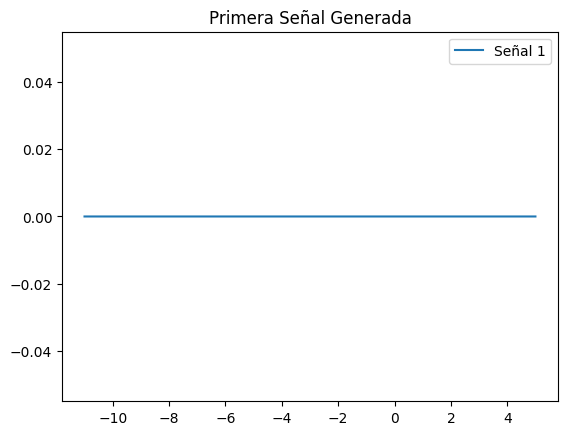

In [5]:
for i, signal in enumerate(generated_signals[:5]):
    plt.plot(t, signal, label=f"Señal {i+1}")
plt.legend()
plt.title("Primera Señal Generada")
plt.show()